# imports

In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    %run /Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py
    mat_path = '/Home/siv30/wad005/master/GRB/MATLAB/andrey_mezentsev/'
else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    mat_path = '/Users/andreas/phys/master/GRB/MATLAB/andrey_mezentsev/'
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time
import scipy.io
import pandas as pd

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example

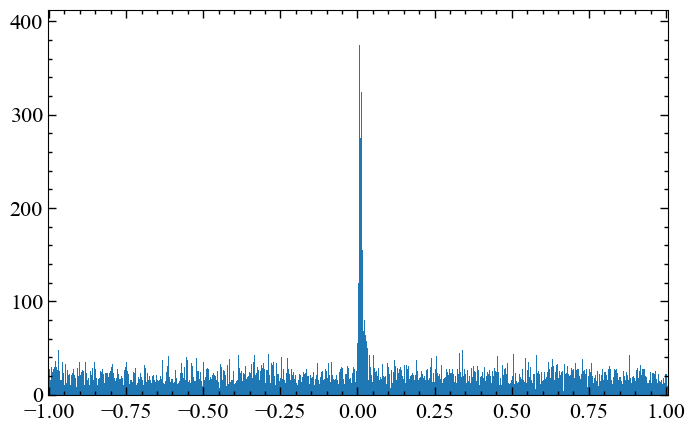

In [4]:
df_asim = pd.read_csv(mat_path_andrey+'GRB190206A.csv')
#working with [s]

tlagg = -0.2955
df_asim['tus'] /= 1e6
df_asim['tus'] += tlagg
tus = df_asim['tus'].to_numpy(dtype=np.float64)
binsize = 0.002 #16ms
bins = np.arange(min(tus),max(tus)+binsize,binsize)
plt.hist(tus,bins=bins)
#plt.vlines(x=-0.0293,ymin=0,ymax=50,color='r')
plt.show()

In [5]:
T0 = datetime.fromisoformat('2019-02-06T03:49:28.525') + timedelta(seconds=tlagg)#cottected_datetime_level1
df_asim = make_adr(df_asim)
df_asim.sort_values(by=['adr','tus'],inplace=True,ignore_index=True)
df_asim.drop(df_asim[df_asim['typ']==3].index, inplace = True) #removed valleys
df_asim.head()

,tus,dau,det,typ,erg,adr
0,-1.000681,1,1,0,299,1
1,-1.000541,1,1,0,1815,1
2,-1.000475,1,1,0,260,1
3,-0.997194,1,1,0,1057,1
4,-0.993957,1,1,0,37,1


In [6]:
#converting to us
df_asim['tus'] *= 1e6
tus,erg,dau,det = df_asim['tus'].to_numpy(dtype=np.float64),df_asim['erg'].to_numpy(),df_asim['dau'].to_numpy(),df_asim['det'].to_numpy()
keV,abc = convert_erg(erg,dau,det,T0)
df_asim['keV'] = keV


st,dt = get_st(df_asim),get_dt(df_asim) #st returned in us
df_asim['st']=st
df_asim['dt']=dt

flag = get_flag(df_asim)
df_asim['flag'] = flag
df_asim.drop(df_asim[get_flag(df_asim)].index,inplace=True)
df_asim.sort_values(by='tus',inplace=True,ignore_index=True)
df_asim['tus'] /= 1e6
print('Safety time: ',np.round((len(np.where(flag==True))/len(tus))*100,3), '% removed')
print('sorted by tus (s)')

Safety time:  0.004 % removed
sorted by tus (s)


In [7]:
df_asim

,tus,dau,det,typ,erg,adr,keV,st,dt,flag
0,-1.001659,3,3,0,30,9,671.7974,0.343595,387.0,False
1,-1.001592,1,2,0,27,2,500.9894,1.001979,0.0,False
2,-1.001460,2,2,0,151,5,1758.1775,6.527258,245.0,False
3,-1.001395,4,3,0,42,12,520.8307,1.041661,1200.0,False
4,-1.001332,3,2,0,20,8,496.4633,0.000000,0.0,False
...,...,...,...,...,...,...,...,...,...,...
24284,1.006495,1,3,0,85,3,881.4072,4.051258,956.0,False
24285,1.006495,3,2,0,72,8,1823.0712,1.548714,302.0,False
24286,1.006632,4,3,0,357,12,4611.8144,13.447258,734.0,False
24287,1.006750,3,1,0,16,7,348.0443,0.000000,3497.0,False


# CC

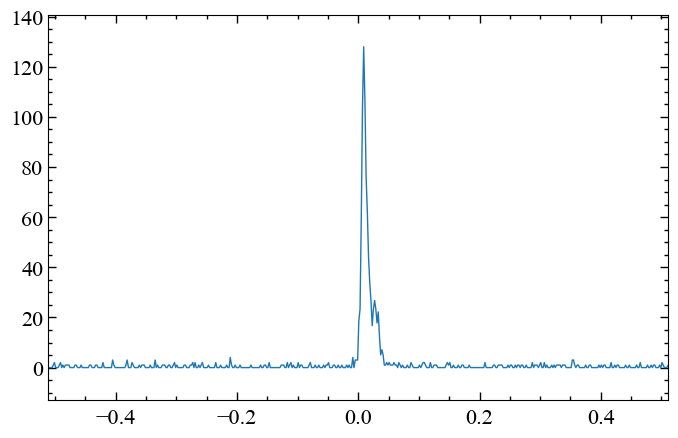

In [8]:
kw_filename = "GRB190206A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>2*binsize)[0][0]

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3

bins = np.append(kw_bin_lo,kw_bin_hi[-1]) #standard bins

kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

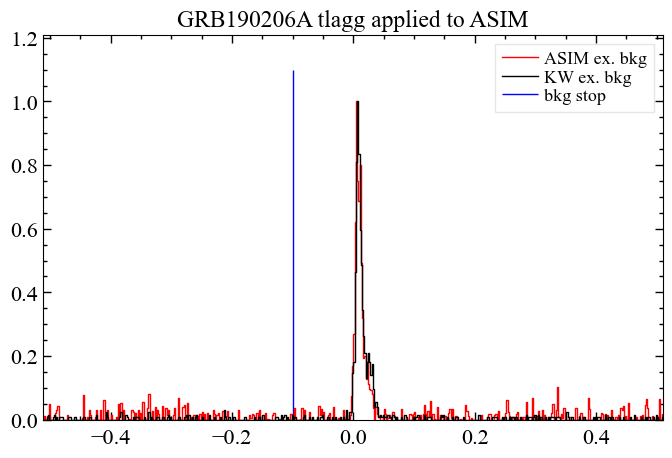

In [10]:
tus_asim = df_asim['tus'].to_numpy()

asim_counts, asim_edges = np.histogram(tus_asim, bins=bins)
j_a_stop = np.searchsorted(asim_edges,-0.10)
asim_counts = np.maximum(asim_counts - np.mean(asim_counts[:j_a_stop]), 0) #removing bkg from ASIM

plt.step(x=asim_edges[:-1], y=asim_counts/max(asim_counts), where='pre', label='ASIM ex. bkg',c='r')
plt.step(x=bins[:-1],y=G3/max(G3),where='pre',label='KW ex. bkg',c='black')
plt.vlines(x=-0.1,ymin=0,ymax=1.1,color='blue',label='bkg stop')
plt.ylim(bottom=0)
plt.legend()
plt.title("GRB190206A tlagg applied to ASIM")
plt.show() #evident that the asim lc must be shifted by ~ -0.6s

In [11]:
asim_lc = LC(time=asim_edges.astype(np.float32)[:-1]+binsize/2,counts=asim_counts.astype(np.int32),skip_checks=True)
kw_lc = LC(time=bins.astype(np.float32)[:-1]+binsize/2,counts=G3.astype(np.int32),skip_checks=True)
np.all(asim_lc.bin_lo == kw_lc.bin_lo)

True

tlagg_asim: 0.0


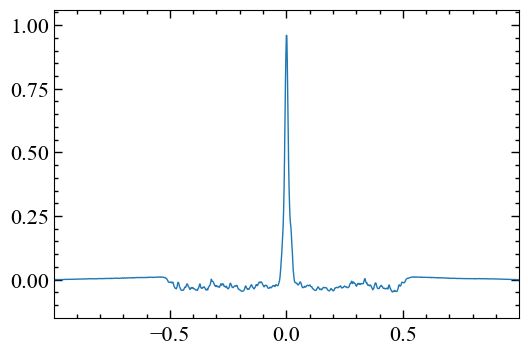

In [12]:
CC_kw_asim = CC(kw_lc,asim_lc,mode='full',norm='variance')
tlagg_asim = CC_kw_asim.time_shift
print(f'tlagg_asim: {tlagg_asim}')
CC_kw_asim.plot()
plt.show()

In [13]:
tlagg_final = tlagg + tlagg_asim
print(tlagg_final)

-0.2955


In [14]:
#need the df for bkg and burst

ix,jx = np.searchsorted(tus_asim,-0.45), np.searchsorted(tus_asim,-0.1)
df_bkg = df_asim.truncate(before=ix,after=jx-1)
df_burst = df_asim.truncate(before=jx)

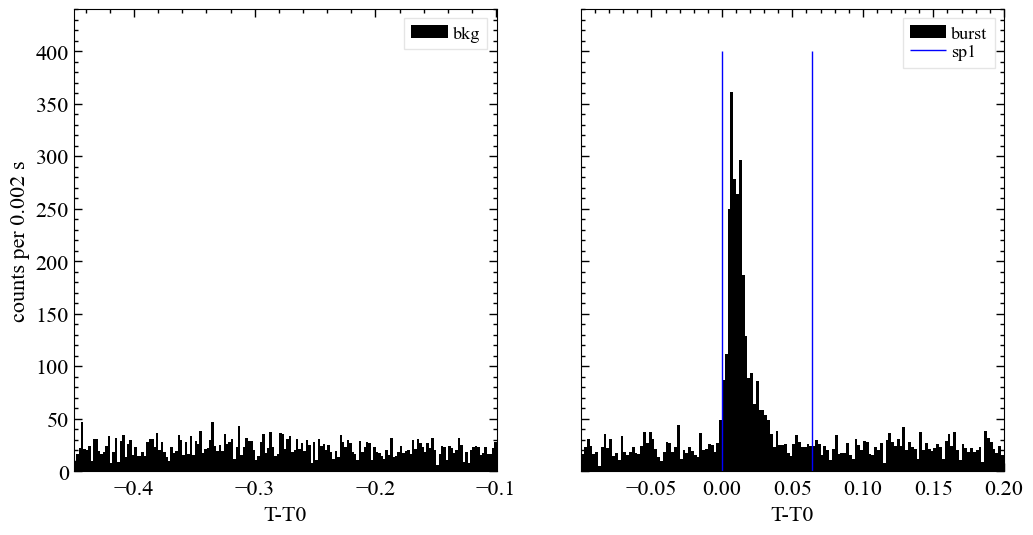

In [22]:
tus_bkg, tus_burst = df_bkg['tus'].to_numpy(), df_burst['tus'].to_numpy()

fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True,figsize=(12, 6))

ax1.hist(tus_bkg,bins=np.arange(min(tus_bkg),max(tus_bkg)+binsize,binsize),label='bkg',color='black')
ax2.hist(tus_burst,bins=np.arange(min(tus_burst),max(tus_burst)+binsize,binsize),label='burst',color='black')
ax2.vlines(x=[0,0.064],ymin=0,ymax=400,color='blue',label='sp1')
ax1.set_xlabel("T-T0")
ax2.set_xlabel("T-T0")
ax1.set_ylabel("counts per 0.002 s")
ax1.legend()
ax2.legend()
ax2.set_xlim(right=0.2)
#plt.savefig('GRB190206A_HED_LC_incBKG.png',dpi=350)
plt.show()

In [23]:
keV_burst = keV_hist(df=df_burst,time_interval=(0.00,0.064),keV_interval='max')

initial len: (14504, 14504)
Start/Stop (1.6000000000016e-05, 0.06378100000000003)
len kev 2902
len tus 2902
mean: 72.55
Energies binned!


In [24]:
keV_bkg = keV_hist(df=df_bkg,time_interval='max',keV_interval='max')

initial len: (3916, 3916)
Start/Stop (-0.449785, -0.10042799999999999)
len kev 3916
len tus 3916
mean: 97.9
Energies binned!


# FITS

In [15]:
%run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
%run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
%run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
%run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

In [25]:
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

### PHA

In [26]:
bin_lo = keV_burst['bins_keV'].to_numpy()[:-1]
bin_hi = keV_burst['bins_keV'].to_numpy()[1:]
counts = keV_burst['counts'].to_numpy()[1:]
err = keV_burst['poisson_error_counts'].to_numpy()[1:]
print(len(bin_lo),len(bin_hi),len(counts),len(err))

tus_burst = df_burst['tus'].to_numpy(dtype=np.float64)
print('Exposure: ',
      np.round(tus_burst[np.searchsorted(tus_burst,0.00)]-
               tus_burst[np.searchsorted(tus_burst,0.064)],6))
print(T0)

40 40 40 40
Exposure:  -0.063984
2019-02-06 03:49:28.229500


In [ ]:
PHA_dict = {
'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
'T0TIME':['2019-02-06T03:49:28.230','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
'TSTART': [0.00,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
'TSTOP': [0.064,'End time of spectrum accumulation'], #<float> [s]
'EXPOSURE': [0.063984,'[s] Integration time in seconds for the PHA data'], #<float> 
'OBJECT': ['GRB190206A','Name of the observed object'], #<str> 
'RA_OBJ': [313.33,'[deg] RA of source'], #<float> 
'DEC_OBJ':  [-30.51,'[deg] Dec of source'], #<float>
'BACKFILE': ['HED_GRB190206A_andrey.bak','Background FITS file'], #<str> ('example.bak')
'RESPFILE': ['HED_GRB190206A_andrey.rsp','Response FITS file'], #<str> ('example.rsp')
'FILENAME': ['HED_GRB190206A_andrey.pha','PHA filename'] #<str>  ('example.pha')
}
generatePHA(PHA_dict=PHA_dict, counts=counts, stat_err=err, bin_lo=bin_lo, bin_hi=bin_hi)

### BAK

In [30]:
bin_lo = keV_bkg['bins_keV'].to_numpy()[:-1]
bin_hi = keV_bkg['bins_keV'].to_numpy()[1:]
counts_bkg = keV_bkg['counts'].to_numpy()[1:]
err_bkg = keV_bkg['poisson_error_counts'].to_numpy()[1:]
print(len(bin_lo),len(bin_hi),len(counts_bkg),len(err_bkg))

tus_bkg = df_bkg['tus'].to_numpy(dtype=np.float64)
print('Exposure: ',
      np.round(tus_bkg[-1]-
               tus_bkg[0],6))
print(T0)

40 40 40 40
Exposure:  0.349357
2019-02-06 03:49:28.229500


In [37]:
print(tus_bkg[-1],tus_bkg[0])

-0.10042799999999999 -0.449785


In [38]:
bak_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-02-06T03:49:28.230','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [-0.1004,'[s] Start time of background accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [-0.45,'End time of background accumulation'], #<float> [s]
    'EXPOSURE': [0.349357,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB190206A','Name of the observed object'], #<str> 
    'RA_OBJ': [313.33,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-30.51,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB190206A_andrey.bak','Backgorund filename'] #<str>  ('example.bak')
}
generateBAK(BAK_dict=bak_dict,bin_lo=bin_lo,bin_hi=bin_hi,bakCounts=counts_bkg,stat_err=err_bkg)

### RSP

In [42]:
rsp_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-02-06T03:49:28.230','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.00,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [0.064,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.064,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB190206A','Name of the observed object'], #<str> 
    'RA_OBJ': [313.33,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-30.51,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB190206A_andrey.rsp','RSP filename'] #<str>  ('example.bak')
}

theta,phi = 110.882,-36.976
drm_path= '/Users/andreas/phys/master/HED_DRM/'
drm_fn=find_DRM_file(dir_path=drm_path,theta=theta,phi=phi)
#drm_fn = 'HED_drm_mats_150.00_-135.00.txt' 
print(drm_fn)
generateRSP(RSP_dict=rsp_dict, 
            DRM_fname=drm_path+drm_fn, 
            bin_lo=bin_lo,
            bin_hi=bin_hi,
            theta=theta,
            phi=phi)

HED_drm_mats_105.00_-30.00.txt
